# CartPole-v0

In [2]:
%matplotlib inline

In [3]:
#! pip install protobuf

In [4]:
from openai.simulator import EpisodeSimulator
from openai.agents.qlearning import EpsilonGreedyTabularQLearner
from openai.agents.random import RandomLearner
from openai.parameters import Epsilon

import gym
import tqdm
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt

In [14]:
env = gym.make('CartPole-v1')
obs = env.reset()
obs

env.render()

[2020-07-06 17:40:32,171] Making new env: CartPole-v1
/Users/andrew.patterson/Library/Caches/pypoetry/virtualenvs/openai-rXQ_zgIa-py3.7/lib/python3.7/site-packages/gym/envs/registration.py:18: PkgResourcesDeprecationWarning: Parameters to load are deprecated.  Call .resolve and .require separately.
  result = entry_point.load(False)


In [15]:
env.observation_space, env.action_space

(Box(4,), Discrete(2))

In [17]:
env.observation_space.sample()

array([ 1.70584725e+00,  1.34890732e+38, -3.08020451e-02, -1.71868464e+37])

## Completely random

In [10]:
agent = RandomLearner(
    action_space=env.action_space,
    state_space=env.observation_space
)

sim = EpisodeSimulator(env, agent, max_timesteps=100)

episodes = 10000

def run_episodes(sim, episodes=10000):
    final_reward_list = []

    for i in tqdm.tqdm(range(episodes)):
        sim.simulate_episode()
        final_reward_list.append(np.sum(sim.reward_list))

    pass_percentage = round(float(sum(final_reward_list))*100. / float(episodes), 2)
    return final_reward_list

In [11]:
print('Running Exploration phase')
random_rewards = run_episodes(sim)

  4%|▍         | 446/10000 [00:00<00:04, 2039.32it/s]

Running Exploration phase


100%|██████████| 10000/10000 [00:03<00:00, 2530.62it/s]


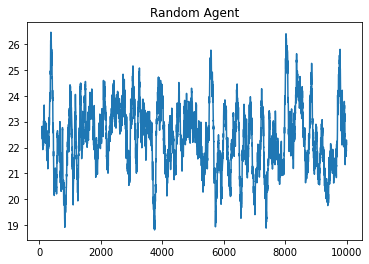

In [12]:
plt.clf()
plt.plot(range(10000), pd.Series(random_rewards).rolling(100).mean())
plt.title('Random Agent')
plt.show()

Doesnt really have a pattern of learning - It needs some optimisation

## Fixed Epsilon Q-Learning

In [13]:
epsilon_rewards_lists = {}
epsilons = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]

for epsilon in epsilons:
    agent = EpsilonGreedyTabularQLearner(
        action_space=env.action_space,
        state_space=env.observation_space,
        epsilon=epsilon
    )
    sim = EpisodeSimulator(env, agent, max_timesteps=100)
    epsilon_rewards_lists[epsilon] = run_episodes(sim)

AttributeError: 'Box' object has no attribute 'n'

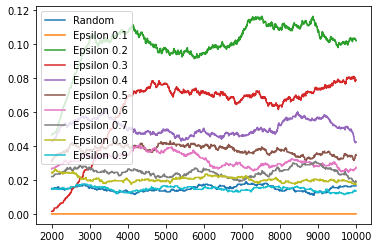

In [58]:
plt.clf()
plt.plot(range(10000), pd.Series(random_rewards).rolling(2000).mean(), label='Random')
for e in epsilons:
    plt.plot(range(10000), pd.Series(epsilon_rewards_lists[e]).rolling(2000).mean(), label=f'Epsilon {e}')

plt.legend(loc='best')
plt.show()

So a low epsilon (0.2) value takes a while but finally learns, while epsilon of 0.3 is faster but then doesnt perform as well

Let's keep those for comparisons

## Decay Epsilon

In [59]:
decay_rewards_lists = {}
decays = [0.0005, 0.001, 0.005, 0.01, 0.05]

for decay in decays:
    agent = EpsilonGreedyTabularQLearner(
        action_space=env.action_space,
        state_space=env.observation_space,
        decay_rate=decay
    )
    sim = EpisodeSimulator(env, agent, max_timesteps=100)
    decay_rewards_lists[decay] = run_episodes(sim)

  2%|▏         | 180/10000 [00:00<00:05, 1796.35it/s]

Reward met 47.22% times


  1%|▏         | 126/10000 [00:00<00:07, 1254.82it/s]

Reward met 0.0% times


  2%|▏         | 158/10000 [00:00<00:06, 1576.04it/s]

Reward met 0.01% times


  1%|▏         | 126/10000 [00:00<00:07, 1249.28it/s]

Reward met 0.0% times


100%|██████████| 10000/10000 [00:07<00:00, 1382.93it/s]

Reward met 0.0% times


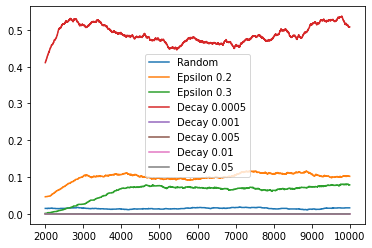

In [62]:
plt.clf()
plt.plot(range(10000), pd.Series(random_rewards).rolling(2000).mean(), label='Random')
for e in [0.2, 0.3]:
    plt.plot(range(10000), pd.Series(epsilon_rewards_lists[e]).rolling(2000).mean(), label=f'Epsilon {e}')
for d in decays:
    plt.plot(range(10000), pd.Series(decay_rewards_lists[d]).rolling(2000).mean(), label=f'Decay {d}')
plt.legend(loc='best')
plt.show()